# TODO


* Add results of Hartigan's dip test https://www.rdocumentation.org/packages/diptest/versions/0.75-7/topics/dip.test

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Lambda$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# What's done:
- Ran mouse max-d without change-of-mind.
- Ran mouse RT for all types.
- Ran walking max-d without change-of-mind.
- Ran walking RT for all types.
- Ran mouse & walking max-d for all trials.
- Ran frequentist regressions.



Load needed libraries

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

Load processed data

In [16]:
get_processed_data <- function(){
    filename <- "C:/Users/Arkady/Google Drive/data/beyond_the_reach/choices_processed.txt"
#     filename <- "../data/choices_processed.txt"
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, 'subj_id'] <- as.factor(data[, 'subj_id'])
    data[, 'option_chosen'] <- as.factor(data[, 'option_chosen'])
    
    return(data)
}

In [17]:
data <- get_processed_data()

Here, I have 2 sets of data for mouse/walking:
one with all trials, one with CoM trials excluded.

In [19]:
data <- get_processed_data()
mouse_data <- data[data$task=='mouse',]

# mouse_data <- mouse_data[complete.cases(mouse_data[ , 'max_d']),]
mouse_data_no_com <- mouse_data[mouse_data$is_com=='False',]

walking_data <- data[data$task=='walking',]
walking_data <- walking_data[complete.cases(walking_data[ , 'max_d']),]
walking_data_no_com <- walking_data[walking_data$is_com=='False',]

In [6]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter))
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior)
    }
    return(model)
}

run_analysis <- function(var, data, rscale){
    " This function runs our analysis for a particular dataset (fake or real) and given DV (var).
    The rscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, var])/sd(data[, 'Lambda'])), class = "b"))

    formulas <- list(f_inter = as.formula(paste(var, "~ (option_chosen | subj_id) + Lambda:option_chosen")),
                     f_choice = as.formula(paste(var, "~ (option_chosen | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    return(bf_result)
}

# Mouse data: max-d without change-of-mind

In [7]:
# rt_bf <- run_analysis('RT', mouse_data, 0.707)
# max_d_bf <- run_analysis('max_d', mouse_data, 0.707)

max_d_bf <- run_analysis('max_d', mouse_data_no_com, 0.707)


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '31974588aee112e6d7d85ce4f8ad66c6' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00051 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.1 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 25.0011 seconds (Warm-up)
Chain 1:                12.7252 seconds (Sampling)
Cha

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '9b7519567c0a170991c10f704a4fe83d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000248 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.48 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 20.6275 seconds (Warm-up)
Chain 1:                13.9412 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '9e0af3661ba6cb6675a9f691ecc5207a' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.9314 seconds (Warm-up)
Chain 1:                2.97464 seconds (Sampling)
Cha

In [8]:
max_d_bf$bf

[,1]         [,2]         [,3]       
[1,] 7.575925e+57 5.459237e+55 0.008408973

In [9]:
spaghetti <- function(model, var, ylabel){
    plt_dat <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=800), plot=FALSE)
    plt_dat <- plt_dat$"Lambda:option_chosen" + 
#         geom_point(aes_string(x="Lambda", y=var, shape='choice', colour='choice'), size = 3, alpha=0.6, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX('Advantage of LL option ($\\lambda$)')) +
        ylab(ylabel) +
        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)

    plot(plt_dat)
#     ggsave(sprintf('figures/spaghetti_%s.png', var), dpi=300) 
}

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


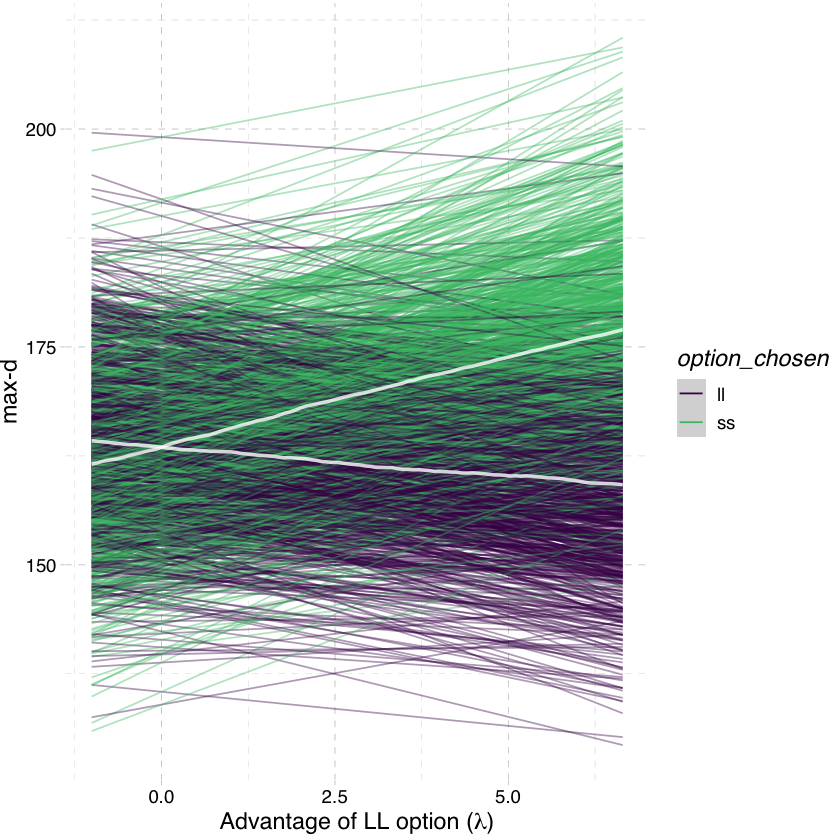

In [10]:
# spaghetti(rt_bf$models$m_inter, 'RT', 'RT')
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [11]:
m <- as.mcmc(max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_mouse_no_com.csv")

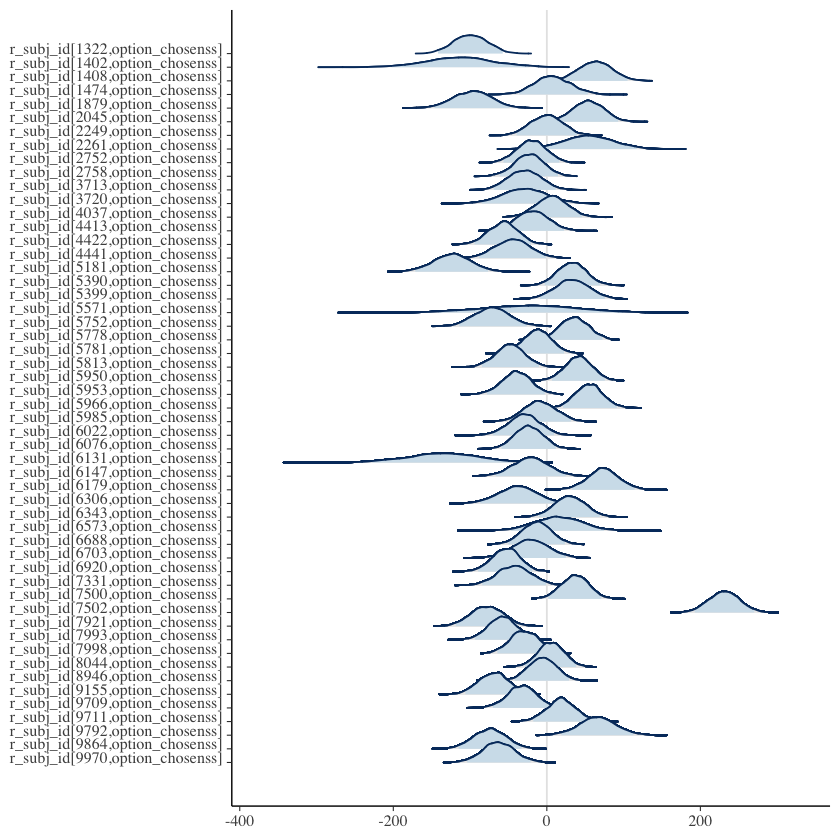

In [12]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Mouse data: max-d including change-of-mind

In [13]:
# rt_bf <- run_analysis('RT', mouse_data, 0.707)
# max_d_bf <- run_analysis('max_d', mouse_data, 0.707)

max_d_bf <- run_analysis('max_d', mouse_data, 0.707)


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '1e76856a78a84d3d3d2d477ff702a5ae' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000391 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.91 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 25.8855 seconds (Warm-up)
Chain 1:                25.0856 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '843074a14d77c988d68dad0fb02815c1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000175 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.75 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 19.1923 seconds (Warm-up)
Chain 1:                8.69048 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '3289fb41a6e375db13a5892ffbb1ed3c' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 5.66515 seconds (Warm-up)
Chain 1:                4.38031 seconds (Sampling)
Ch

In [14]:
max_d_bf$bf

[,1]        [,2]         [,3]    
[1,] 1.42866e+74 2.607489e+75 20.20852

In [15]:
spaghetti <- function(model, var, ylabel){
    plt_dat <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=800), plot=FALSE)
    plt_dat <- plt_dat$"Lambda:option_chosen" + 
#         geom_point(aes_string(x="Lambda", y=var, shape='choice', colour='choice'), size = 3, alpha=0.6, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX('Advantage of LL option ($\\lambda$)')) +
        ylab(ylabel) +
        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)

    plot(plt_dat)
#     ggsave(sprintf('figures/spaghetti_%s.png', var), dpi=300) 
}

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


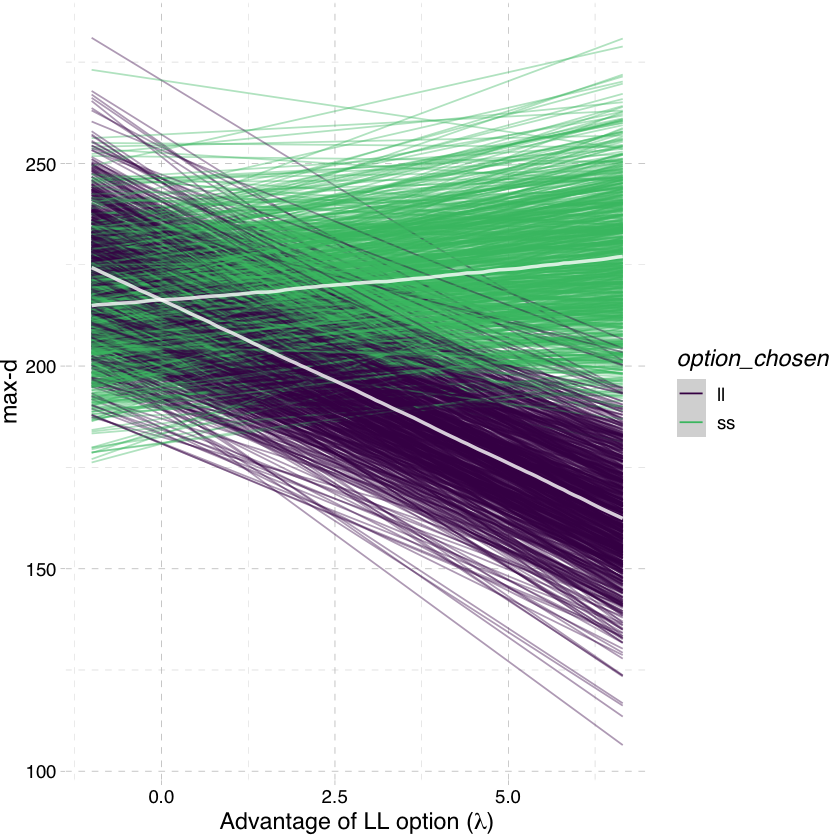

In [16]:
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [17]:
m <- as.mcmc(max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_mouse_including_com.csv")

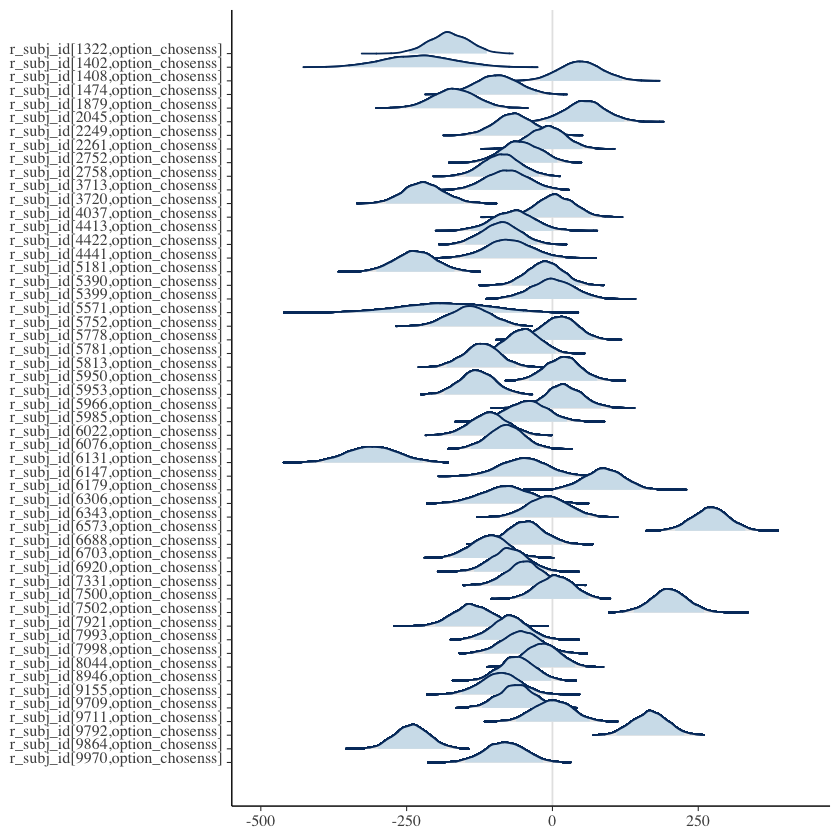

In [18]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Mouse data: RT

In [19]:
rt_bf <- run_analysis('RT', mouse_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '797c25c42186ff93b21e5d01422eb28f' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000242 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.42 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 33.3946 seconds (Warm-up)
Chain 1:                29.6591 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '3c149e5890a136f98e3a460a43e9eba9' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000176 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.76 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 15.8018 seconds (Warm-up)
Chain 1:                15.6648 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'be17b3a33f4c9d3ed7604ac0c3eaf4ef' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.92 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.31268 seconds (Warm-up)
Chain 1:                2.38901 seconds (Sampling)
Ch

In [20]:
rt_bf$bf

[,1]     [,2]         [,3]        
[1,] 32775515 9.034735e+18 247025368431

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


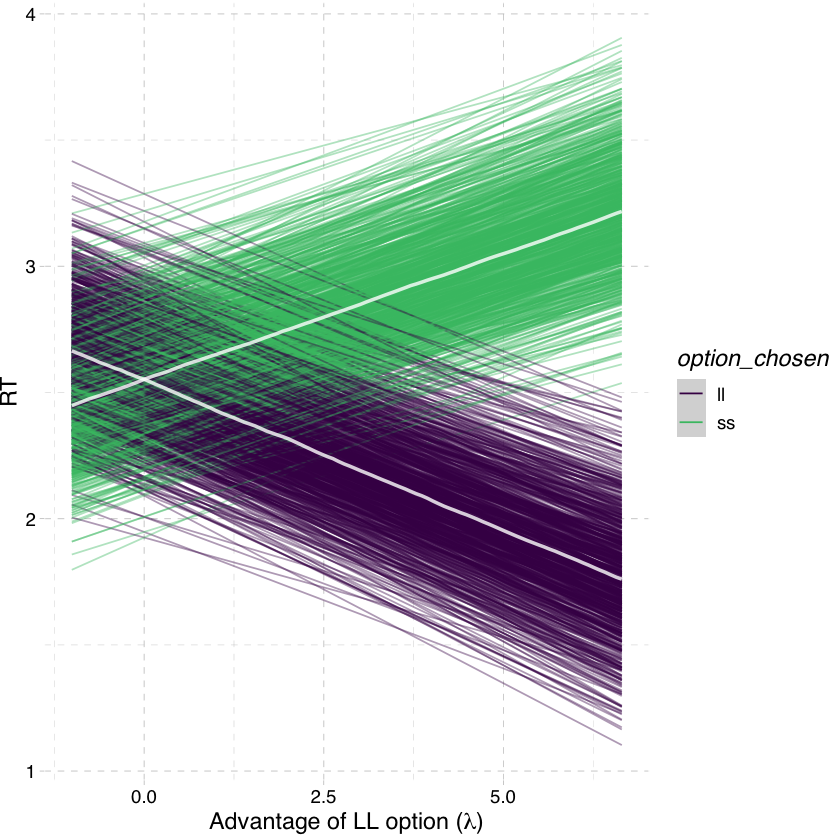

In [21]:
spaghetti(rt_bf$models$m_inter, 'RT', 'RT')

In [22]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "RT_mouse_all_coeffs.csv")

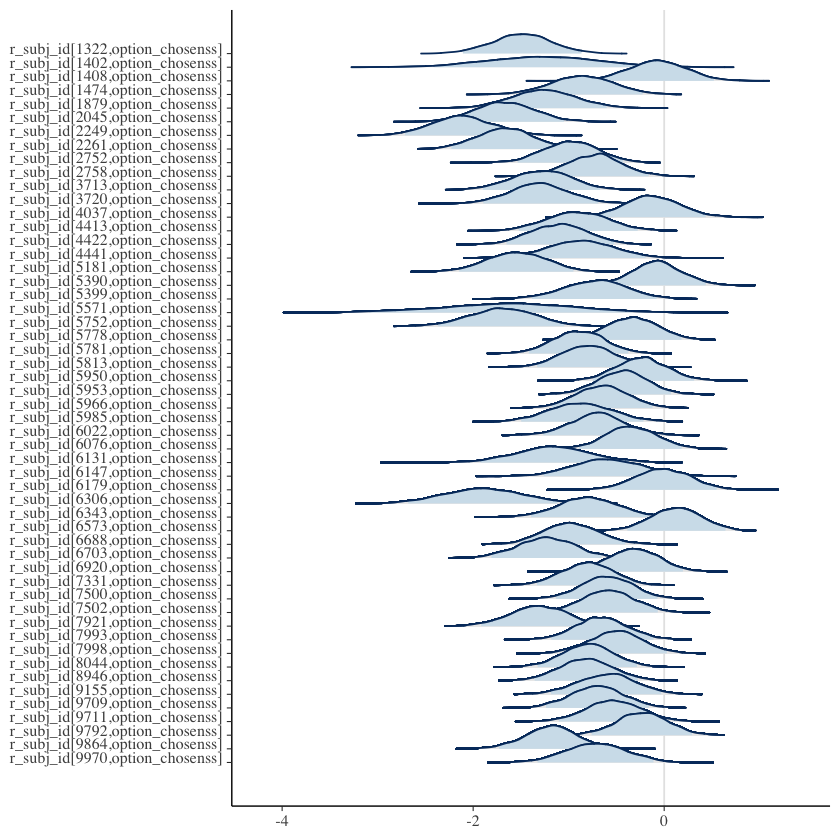

In [23]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Walking data: max-d without CoM

In [24]:
max_d_bf <- run_analysis('max_d', walking_data_no_com, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '95cac8b00bc525d091b153bff756db5e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00027 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.7 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 37.3629 seconds (Warm-up)
Chain 1:                22.3863 seconds (Sampling)
Cha

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '27c3e49e8b5dd0e24f6c023c670266bc' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000231 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.31 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 23.2997 seconds (Warm-up)
Chain 1:                11.1173 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'e471845673ed1740f839e3fc5f60b105' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 6.78263 seconds (Warm-up)
Chain 1:                2.165 seconds (Sampling)
Chai

In [25]:
#     bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
max_d_bf$bf

[,1]         [,2]         [,3]    
[1,] 2.956791e+58 3.815903e+65 13721085

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


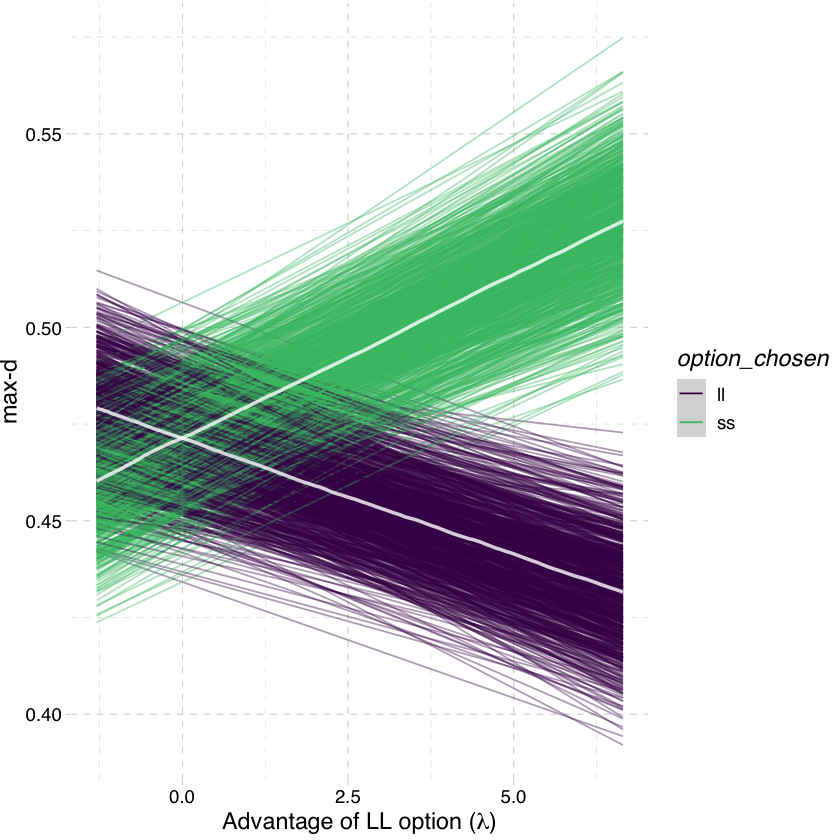

In [26]:
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [27]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_walking_no_com.csv")

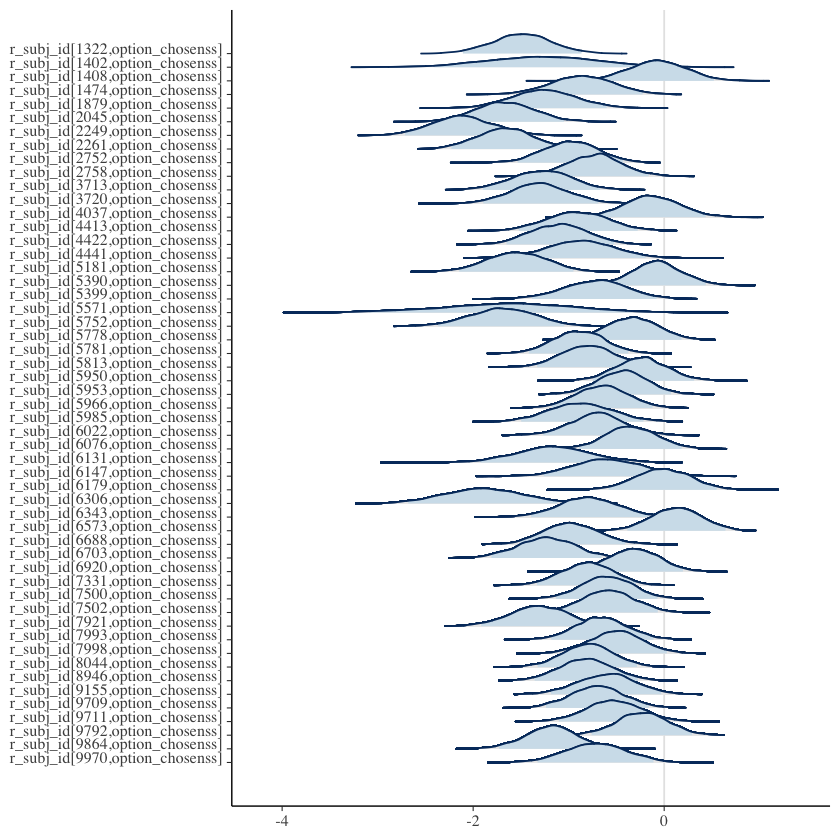

In [28]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Walking data: max-d including CoM

In [35]:
max_d_bf <- run_analysis('max_d', walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '983632ceedc8c33bb8ba128a37abcb41' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000282 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.82 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 34.837 seconds (Warm-up)
Chain 1:                23.7274 seconds (Sampling)
Ch

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '64090ecdde5c702d84283d03396b7f95' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000178 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.78 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 21.9656 seconds (Warm-up)
Chain 1:                13.8033 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '84bad489802588d04d4a235f4a79347f' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 6.87548 seconds (Warm-up)
Chain 1:                4.10578 seconds (Sampling)
Ch

In [34]:
# hpd_inter<-HPDinterval(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE))

# mcmc_areas_ridges(as.matrix(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE)), regex_pars = "b_Lambda", prob=0.95)
# hpd_inter[c('b_Lambda:choiceLL', 'b_Lambda:choiceSS'),]

In [36]:
#     bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
max_d_bf$bf

[,1]         [,2]         [,3]    
[1,] 3.759542e+67 9.445574e+74 28674788

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


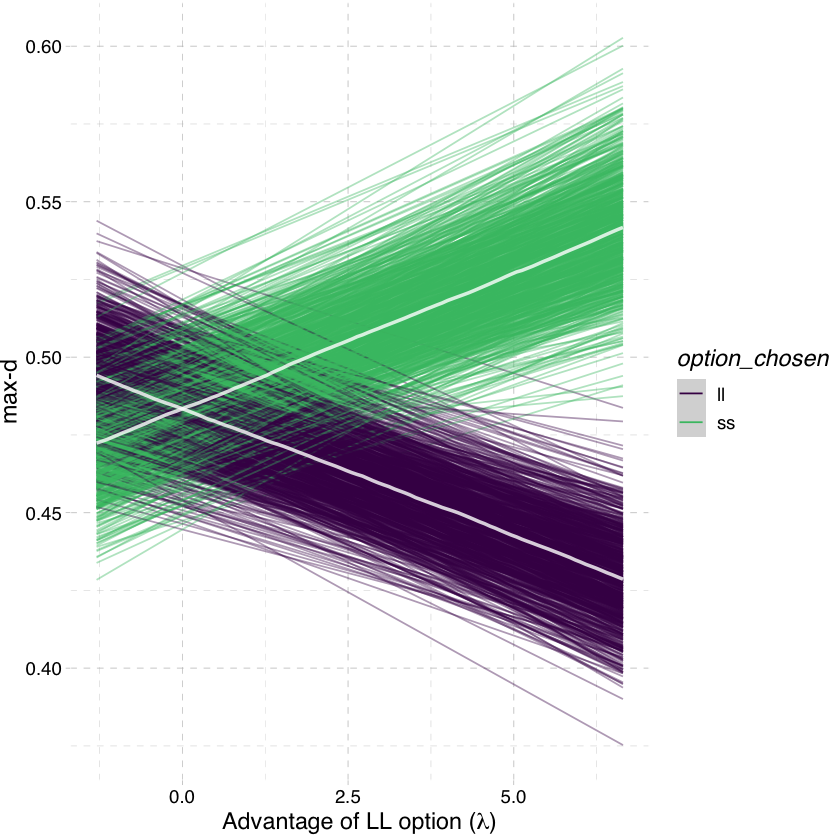

In [37]:
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [38]:
m <- as.mcmc(max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_walking_including_com.csv")

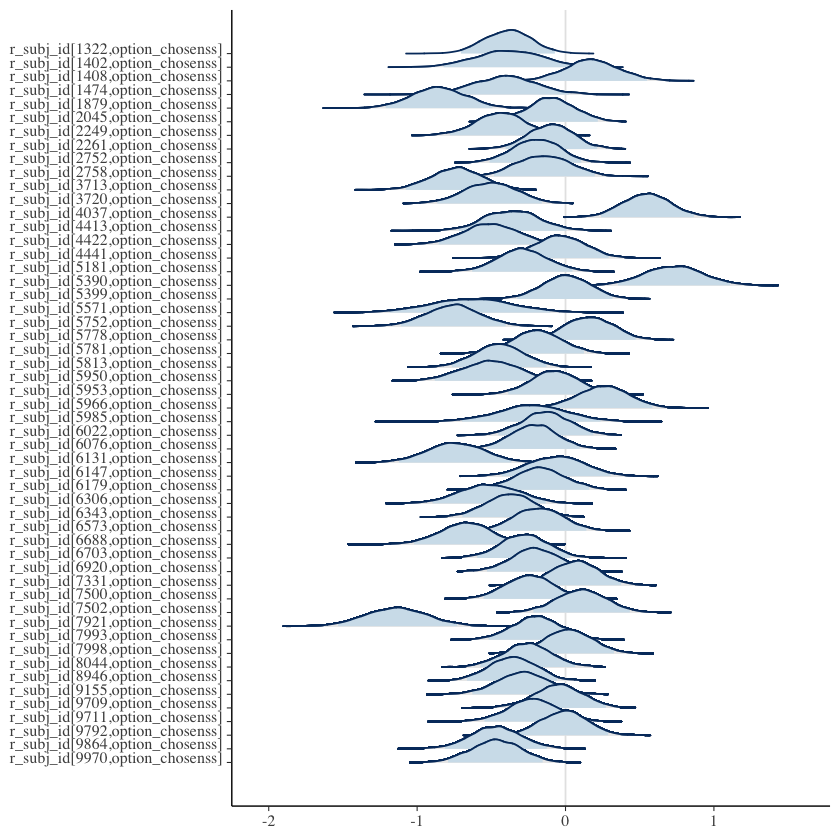

In [39]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Walking data: RT

In [29]:
rt_bf <- run_analysis('RT', walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'fed15a795f3a6cdd8dee64bee5779364' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000247 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.47 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 36.5974 seconds (Warm-up)
Chain 1:                31.4509 seconds (Sampling)
C

Warning message:
“There were 5 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'd98e35438d4487cac23374fa66bc1b8e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000183 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.83 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 26.0751 seconds (Warm-up)
Chain 1:                16.7246 seconds (Sampling)
C

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL '66af642df4752983c37bb5e7b69c034d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.55132 seconds (Warm-up)
Chain 1:                4.10663 seconds (Sampling)
Ch

In [30]:
rt_bf$bf

[,1]        [,2]         [,3]    
[1,] 1.58924e+11 9.849818e+15 73641.62

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


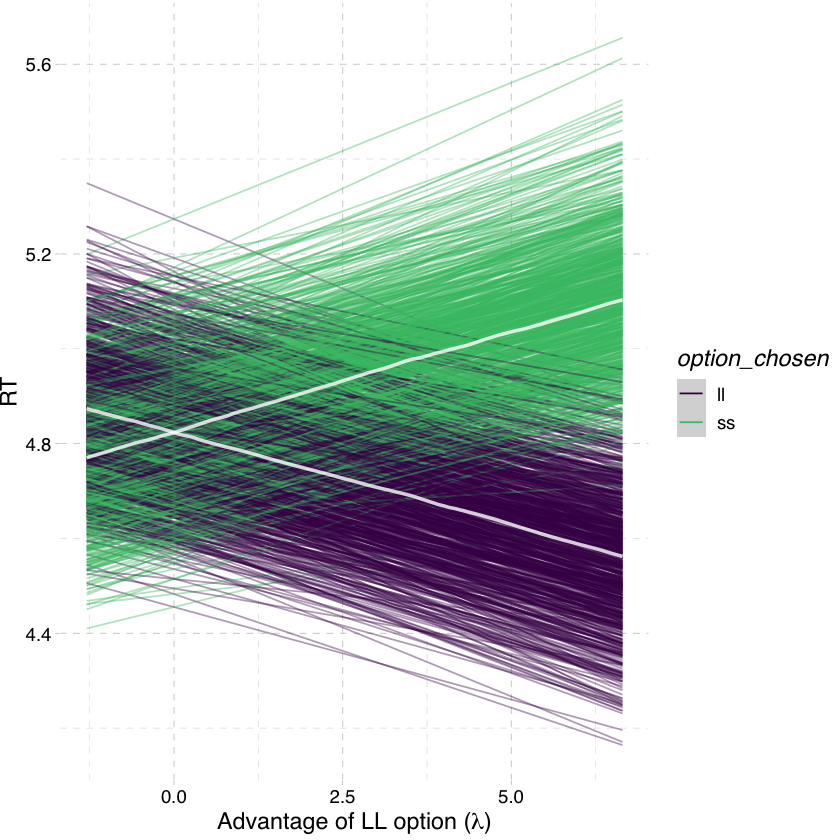

In [31]:
spaghetti(rt_bf$models$m_inter, 'RT', 'RT')

In [32]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "RT_walking_all_coeffs.csv")

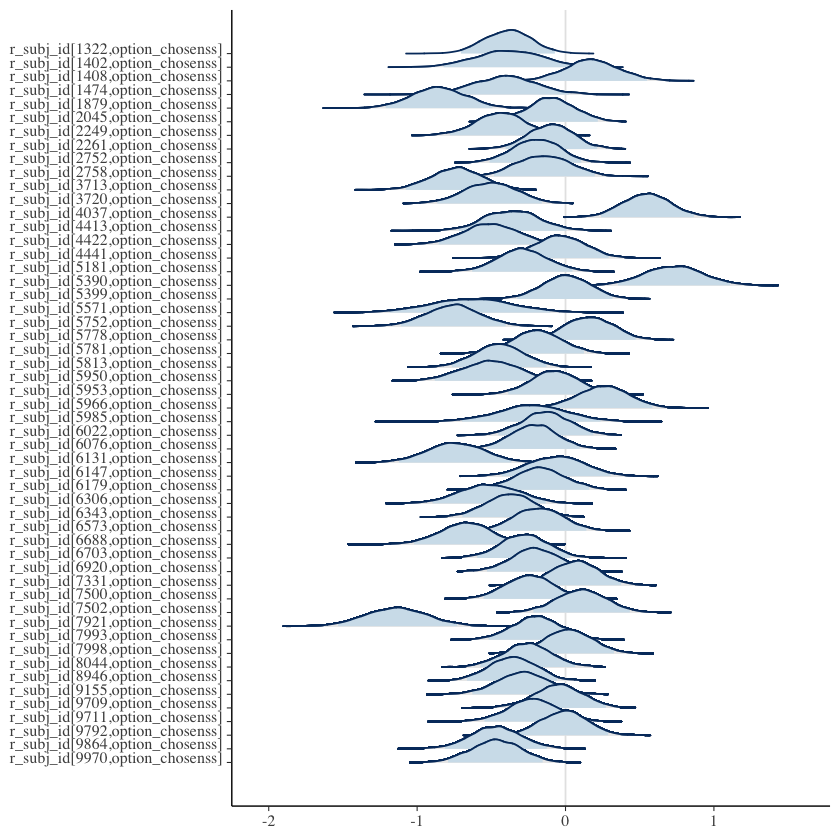

In [33]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",option_chosen", prob=0.95) 

# Frequentist regressions

Just to check whether the results of Bayesian regressions are consistent with their frequentist counterparts. In all cases (max-d/RT, mouse/walking), the models involving choice-by-$\Lambda$ interaction are most supported by the data. However, in mouse data without changes-of-mind, the choice-only model is most likely.

In [8]:
library(coin)
library(lme4)
library(lmerTest)
library(plyr)
library(xtable)
library(LMERConvenienceFunctions)
library(car)

source("r_utils/mer-utils.R")
source("r_utils/regression-utils.R")

Warning message:
"package 'coin' was built under R version 3.5.2"Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:brms':

    kidney


Attaching package: 'lme4'

The following object is masked from 'package:brms':

    ngrps

The following object is masked from 'package:gmm':

    checkConv

Warning message:
"package 'lmerTest' was built under R version 3.5.2"
Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step


Attaching package: 'xtable'

The following objects are masked from 'package:mefa':

    label, label<-

Loading required package: carData


In [11]:

mouse_data$choice = 0

mouse_data$choice[mouse_data$option_chosen == 'ss'] = 1

walking_data$choice = 0

walking_data$choice[walking_data$option_chosen == 'ss'] = 1

# Mouse data: RT Vs Choice

In [24]:
rt_mouse_analysis <- function(stats.df){
    choice.mer = lmer(RT ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="RT_vs_choice_mouse.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:RT_vs_choice",
                 caption = 'RT as a function of choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}


In [26]:
rt_mouse_analysis(mouse_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 6915.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5887 -0.5512 -0.1424  0.3361  4.7824 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     1.7439   1.3206        
          option_chosenss 1.0786   1.0385   -0.86
 Residual                 0.8244   0.9079        
Number of obs: 2490, groups:  subj_id, 54

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               2.49865    0.09939   59.48934  25.141  < 2e-16 ***
option_chosenll:Lambda   -0.11765    0.01571  816.93829  -7.487 1.83e-13 ***
option_chosenss:Lambda    0.09829    0.01520 2448.77720   6.468 1.19e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           

Effects of $\Lambda$ on RT (moderated by choice) are in place even if CoM's are dropped

In [27]:
rt_mouse_analysis(mouse_data_no_com)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 5968.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4171 -0.5564 -0.1339  0.3309  4.9942 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.9902   0.9951        
          option_chosenss 0.6161   0.7849   -0.73
 Residual                 0.7164   0.8464        
Number of obs: 2263, groups:  subj_id, 54

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               2.55999    0.09820   58.46611  26.070  < 2e-16 ***
option_chosenll:Lambda   -0.07844    0.01491  374.89325  -5.261 2.42e-07 ***
option_chosenss:Lambda    0.10147    0.01452 2221.63829   6.990 3.62e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           

# Mouse data: max-d vs choice

In [34]:
max_d_mouse_analysis <- function(stats.df){
    choice.mer = lmer(max_d ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="max_d_vs_choice_mouse.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:max_d_vs_choice",
                 caption = 'max_d as a function of choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}

In [35]:
max_d_mouse_analysis(mouse_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 30403.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7935 -0.4694 -0.1030  0.2642  6.3501 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     10241    101.2         
          option_chosenss 15225    123.4    -0.64
 Residual                 10392    101.9         
Number of obs: 2490, groups:  subj_id, 54

Fixed effects:
                       Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)             217.597     11.492   65.150  18.935  < 2e-16 ***
option_chosenll:Lambda   -7.714      1.779 1130.646  -4.337 1.58e-05 ***
option_chosenss:Lambda    1.357      1.713 2445.162   0.792    0.428    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
             (Intr) opt

# Walking data: RT Vs Choice

In [43]:
rt_walking_analysis <- function(stats.df){
    choice.mer = lmer(RT ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="RT_vs_choice_walking.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:RT_vs_choice",
                 caption = 'RT as a function of choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}


In [44]:
rt_mouse_analysis(walking_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 4450.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6080 -0.6300 -0.1584  0.4395  6.3999 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.6713   0.8194        
          option_chosenss 0.1868   0.4322   -0.49
 Residual                 0.3118   0.5584        
Number of obs: 2451, groups:  subj_id, 54

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             4.845e+00  9.925e-02  5.572e+01  48.812  < 2e-16 ***
option_chosenll:Lambda -3.460e-02  8.718e-03  4.212e+02  -3.969 8.49e-05 ***
option_chosenss:Lambda  4.461e-02  9.650e-03  2.388e+03   4.622 4.00e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           

# Walking data: max-d vs choice

In [41]:
max_d_walking_analysis <- function(stats.df){
    choice.mer = lmer(max_d ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="max_d_vs_choice_walking.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:max_d_vs_choice",
                 caption = 'max_d as a function of choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}

In [42]:
max_d_walking_analysis(walking_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: -4023.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6272 -0.5803 -0.0822  0.4605 10.1332 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.008278 0.09099       
          option_chosenss 0.014688 0.12119  -0.55
 Residual                 0.009820 0.09910       
Number of obs: 2451, groups:  subj_id, 54

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             4.829e-01  1.140e-02  6.782e+01  42.379  < 2e-16 ***
option_chosenll:Lambda -8.418e-03  1.689e-03  1.241e+03  -4.985 7.09e-07 ***
option_chosenss:Lambda  8.992e-03  1.731e-03  2.400e+03   5.193 2.24e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
       